#Store Sales - Time Series Forecasting


## Description

The dataset contains historical sales data from Corporación Favorita, a major grocery retail chain in **Ecuador** with operations across several South American countries.

### Data Structure

The dataset includes multiple files that capture various aspects of store sales over time. \
The dataset includes data from **54 stores** and **33 product families**, with a time series spanning from **January 1, 2013**, to **August 31, 2017**. \
The dates in the test data are for the **15 days after** the last date in the training data



Our main goal is predicting sales for each product family and store combinations.



There are 6 data files: \
1. **stores**
2. **transactions**
3. **oil**
4. **holidays_event**
5. **train**
6. **test**


### Variables for each data file

**Stores** file gives some information about stores such as city, state, type, cluster \
**Transactions** is highly correlated with train's sales column. You can understand the sales patterns of the stores. \
**Oil** is a daily price of oil. Oil is the main export from Ecuador \
**Holidays_events** file is a meta data. This data is quite valuable to understand past sales, trend and seasonality components. However, it needs to be arranged. You are going to find a comprehensive data manipulation for this data. That part will be one of the most important chapter in this notebook. \
**Train** data contains time series of the stores and the product families combination. The sales column gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units. The onpromotion column gives the total number of items in a product family that were being promoted at a store at a given date.

### Steps in this Notebook

1. **Importing the libraries, data loading and inspection** \
We start by importing the important libraries, which we will use, loading the dataset and examining its structure to understand the types of data we're working with, and review key statistics.

2. **Data Cleaning and Preparation** \
After the inspection data, we clean the data as needed. This includes handling missing values, formatting dates, and setting up the data in a time series format, which is essential for time-series modeling.


3. **Exploratory Data Analysis (EDA)** \
Through visualizations, we explore trends, seasonality, and any cyclic patterns in the data. This step helps us understand the key drivers of sales and spot any unusual patterns that could affect forecasting accuracy.


4. **Modeling and Forecasting** \
Using , we build a forecasting model to predict future sales. We split the data into training and test sets to validate the model's accuracy, adjusting parameters as needed to improve performance.

5. **Evaluation and Visualization of Results** \
We assess the model's performance using error metrics like Mean Squared Error (MSE). We also visualize the model's predictions alongside actual sales data to understand its effectiveness in capturing trends.



6. **Future Sales Forecasting** \
With the validated model, we make future sales predictions and visualize these forecasts to provide actionable insights into expected sales patterns.

7. **Conclusions and Next Steps** \
Finally, we summarize our findings, discuss the model’s performance, and suggest potential improvements or additional analyses that could enhance forecasting accuracy.

## Notebook

In [1]:
## IMPORT LIBRARIES

# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# MODELING
# ------------------------------------------------------
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import xgboost as xgb

In [2]:
## DATA LOADING

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])

In [3]:
# DATA TIME
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
# DATA TYPES
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [4]:
train.head(100)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0
...,...,...,...,...,...,...
95,95,2013-01-01,11,PREPARED FOODS,0.0,0.0
96,96,2013-01-01,11,PRODUCE,0.0,0.0
97,97,2013-01-01,11,SCHOOL AND OFFICE SUPPLIES,0.0,0.0
98,98,2013-01-01,11,SEAFOOD,0.0,0.0


In [5]:
train.shape # +1 column added

(3000888, 6)

In [6]:
test.shape

(28512, 5)

The train data set consists of 3000888 rows and 6 columns, test consists of 28512 rows and 5 columns. So, it's great.

In [7]:
# Function to Check Missing Values
def missing_values(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(f"Missing values in {name}:")
        print(missing)
        print("\n")
    else:
        print(f"No missing values in {name}.\n")

In [8]:
# Check Missing Values
missing_values(train, 'train.csv')
missing_values(test, 'test.csv')
missing_values(stores, 'stores.csv')
missing_values(oil, 'oil.csv')
missing_values(holidays_events, 'holidays_events.csv')
missing_values(transactions, 'transactions.csv')

No missing values in train.csv.

No missing values in test.csv.

No missing values in stores.csv.

Missing values in oil.csv:
dcoilwtico    43
dtype: int64


No missing values in holidays_events.csv.

No missing values in transactions.csv.



We don't have missing values in  datasets, except oil.csv but we ignore it.

Let's get to Exploratory Data Analysis (EDA) \
Firslty, we wil focus on transcations

In [9]:
transactions.head(100)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
95,2013-01-04,3,3188
96,2013-01-04,4,1596
97,2013-01-04,5,1642
98,2013-01-04,6,1679


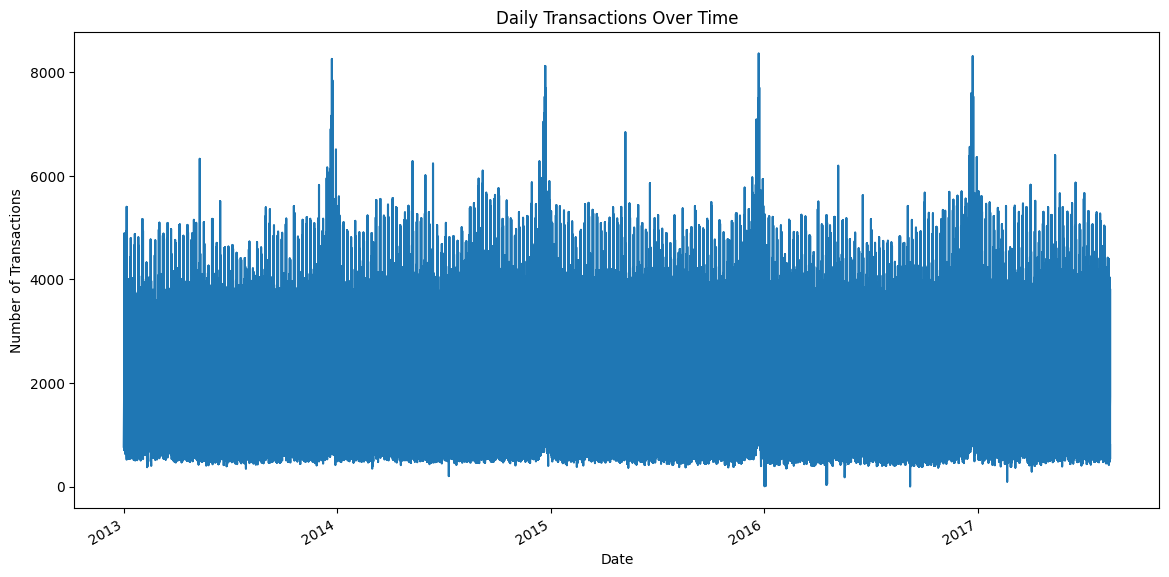

In [10]:
## Transactions Over Time
plt.figure(figsize=(14,7))
transactions.set_index('date')['transactions'].plot()
plt.title('Daily Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

There is a consistent pattern in the transactions, with all months showing similar trends except for December, which stands out from 2013 to 2017, as seen in the plot.

In [11]:
# Creating temporary df
df_1 = transactions.copy()

# Adding 'year' and 'dayofweek' columns
df_1["year"] = df_1.date.dt.year
df_1["dayofweek"] = df_1.date.dt.dayofweek + 1  # Day of week (1-7)

# Grouping data by year and day of the week, calculating average transactions
df_1 = df_1.groupby(["year", "dayofweek"]).transactions.mean().reset_index()

# Plot
fig = px.line(df_1, x="dayofweek", y="transactions", color="year", title="Transactions by Day of Week")
fig.show()

From this plot, we can notice that the day of the week also has an impact on transactions, with the largest number occurring on weekends.


Now, let’s move on to the datasets: train and test, and focus on the most important column, **sales**.

In this section, we will analyze the sales data, which is crucial for forecasting. The train dataset includes historical sales data, allowing us to understand trends, seasonality, and other patterns. Starting from correlation between each stores.

<ipython-input-12-d87f6041c6db>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-d87f6041c6db>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



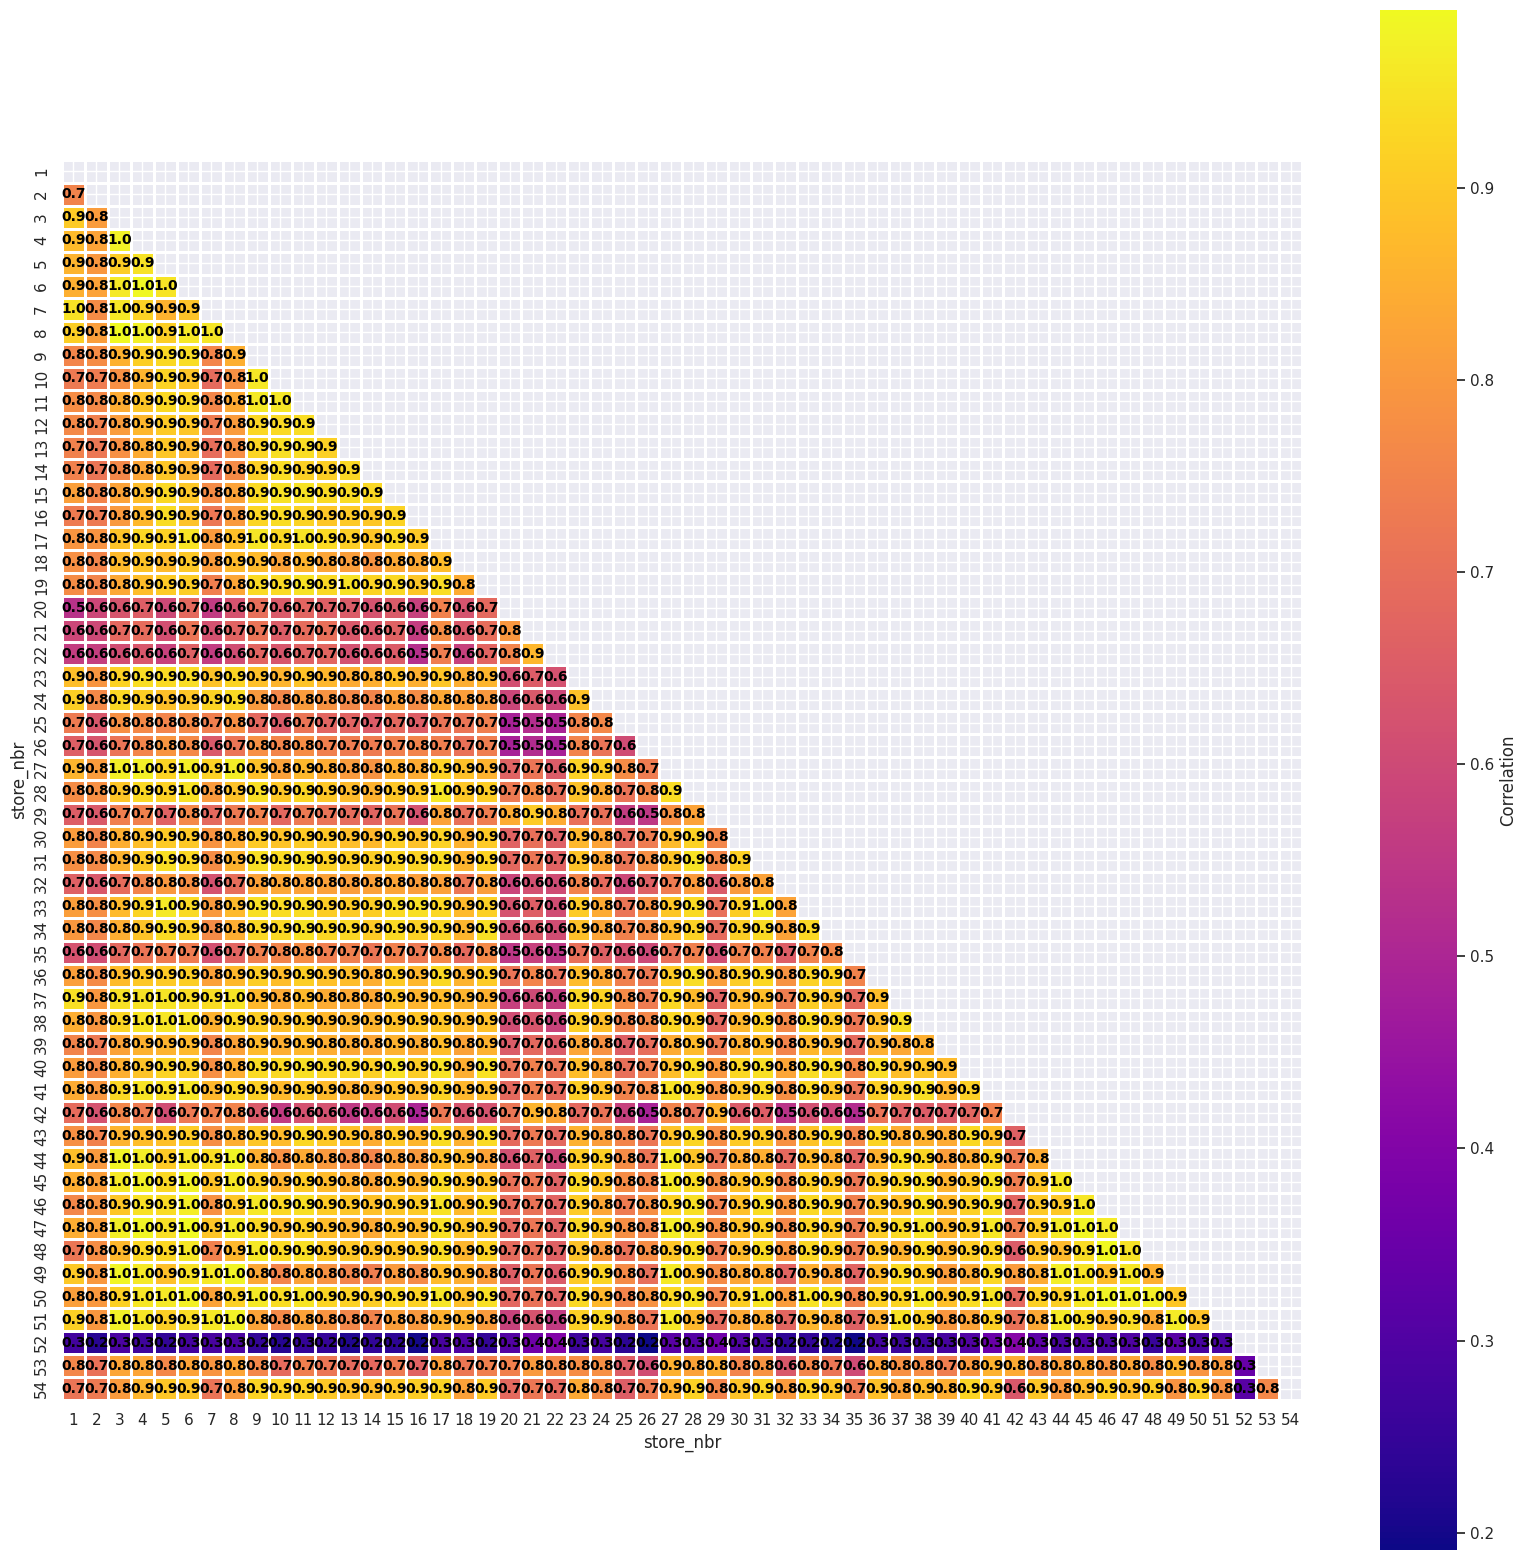

In [12]:
df_2 = train[["store_nbr", "sales"]]
df_2["ind"] = 1
df_2["ind"] = df_2.groupby("store_nbr").ind.cumsum().values
df_2 = pd.pivot(df_2, index="ind", columns="store_nbr", values="sales").corr()

# Apply a custom mask to only show the upper triangle of the correlation matrix
mask = np.triu(df_2.corr())

# Set the style to dark and choose a different color palette
sns.set_theme(style="darkgrid", palette="viridis")

plt.figure(figsize=(20, 20))

# Plotting the heatmap with customized aesthetics
sns.heatmap(df_2,
            annot=True,
            fmt='.1f',
            cmap='plasma',  # 'magma', 'inferno', or 'plasma'
            square=True,
            mask=mask,
            linewidths=1,
            cbar=True,
            cbar_kws={'label': 'Correlation'},
            annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'})

plt.title("Correlations Among Stores", fontsize=24, weight='bold', color='white')
plt.show()

Like we see, most of the stores are similar to each other

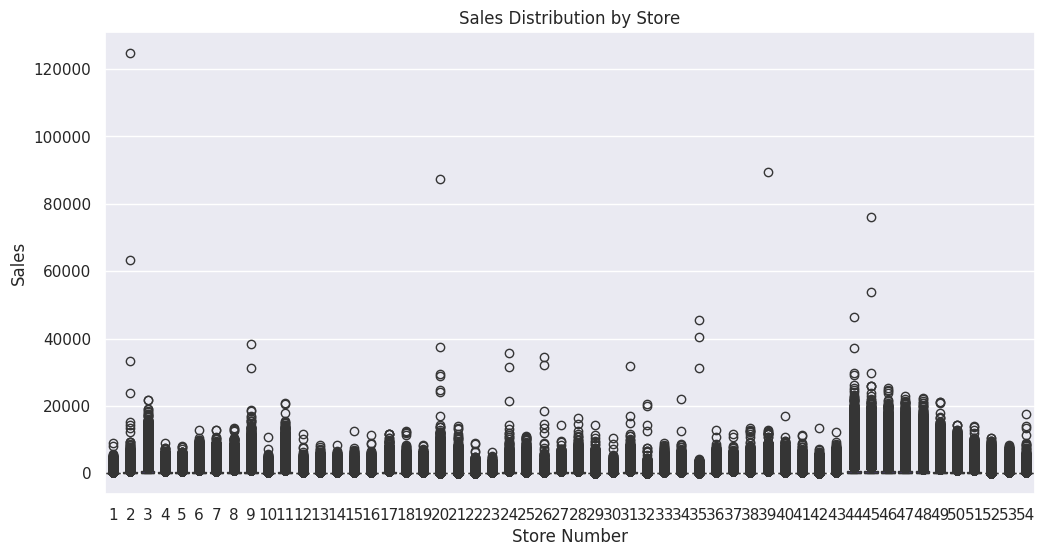

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='store_nbr', y='sales', data=train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()

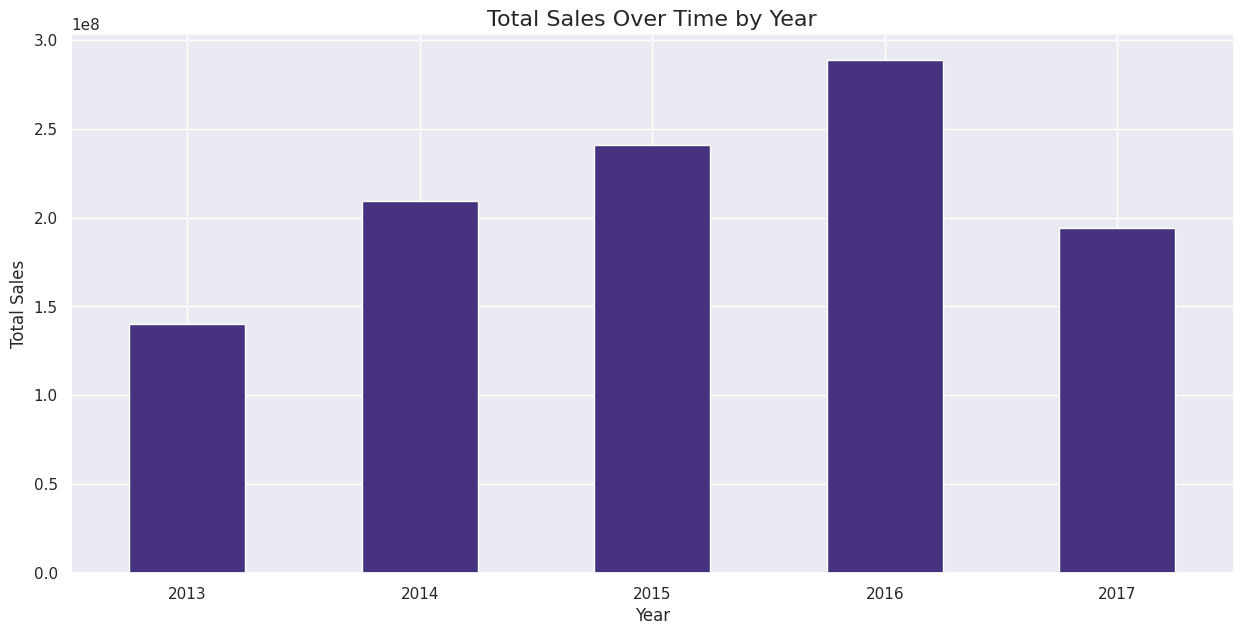

In [14]:
train['year'] = train['date'].dt.year
sales_by_year = train.groupby('year')['sales'].sum()


plt.figure(figsize=(15, 7))
sales_by_year.plot(kind='bar')

plt.title('Total Sales Over Time by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=0)
plt.show()

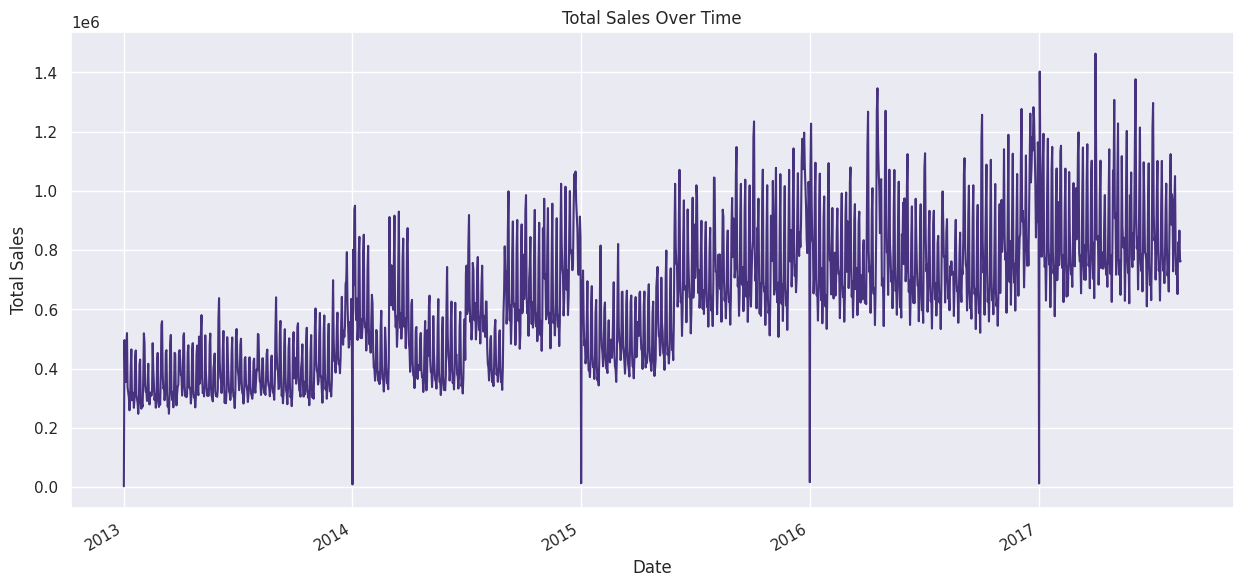

In [15]:
plt.figure(figsize=(15,7))
train.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

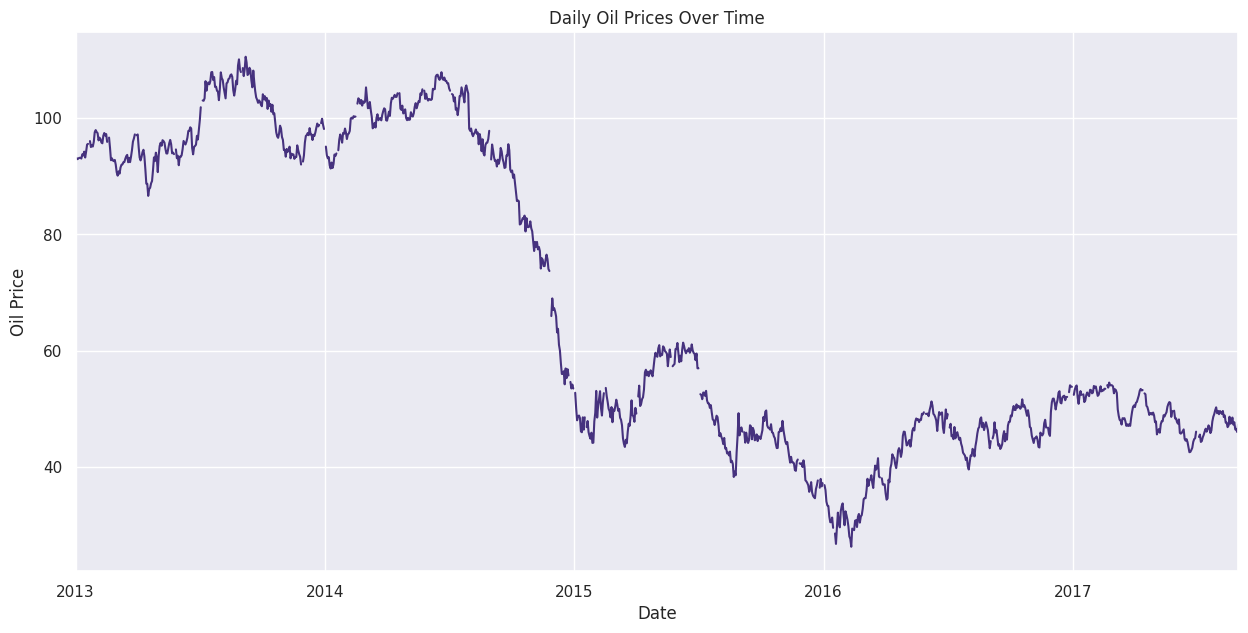

In [16]:
plt.figure(figsize=(15,7))
oil.set_index('date')['dcoilwtico'].plot()
plt.title('Daily Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

Oil prices may affect the prediction model we make, so I will add it to the training and test data set


In [17]:
train = pd.merge(train, oil, on='date', how='left', suffixes=('', '_y'))
test = pd.merge(test, oil, on='date', how='left', suffixes=('', '_y'))

In [18]:
train.columns.tolist() #dcoilwtico is a price of oil

['id',
 'date',
 'store_nbr',
 'family',
 'sales',
 'onpromotion',
 'year',
 'dcoilwtico']

In [19]:
test.columns.tolist() #dcoilwtico is a price of oil

['id', 'date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico']

In [20]:
# Add 'is_train' flag to distinguish between train and test after concatenation
train['is_train'] = 1
test['is_train'] = 0